In [157]:
import torch
import torch.nn as nn
from torch.nn.modules import rnn
from torchsummary import summary
import torchvision
from torchview import draw_graph
import numpy as np

In [61]:
num_actions = 12
mlp_input_dim_a = 55
actor_hidden_dims = [512, 256, 128]
activation = nn.ELU()

img_height = 300
img_width = 250

con2D = nn.Conv2d(1, 3, 10, stride=2)
flatten = nn.Flatten()
img_brunch = nn.Sequential(con2D, activation, flatten)

data_brunch = nn.Linear(mlp_input_dim_a, mlp_input_dim_a)

# concat = torch.cat(img_brunch, data_brunch)

actor_layers = []
actor_layers.append(nn.Linear(mlp_input_dim_a, actor_hidden_dims[0]))
actor_layers.append(activation)
for l in range(len(actor_hidden_dims)):
    if l == len(actor_hidden_dims) - 1:
        actor_layers.append(nn.Linear(actor_hidden_dims[l], num_actions))
    else:
        actor_layers.append(nn.Linear(actor_hidden_dims[l], actor_hidden_dims[l + 1]))
        actor_layers.append(activation)
actor = nn.Sequential(*actor_layers)

print(actor)

# model_graph = draw_graph(actor, input_size=[(1, 300,200), (1, 55)], expand_nested=True)
# model_graph.visual_graph

Sequential(
  (0): Linear(in_features=55, out_features=512, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=128, out_features=12, bias=True)
)


CNNandFC(
  (conv2D): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(5, 5))
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp): Sequential(
    (0): Linear(in_features=17395, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=12, bias=True)
  )
)


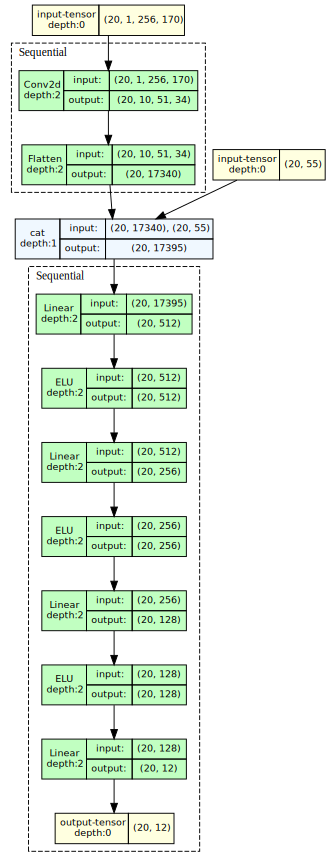

In [239]:
def get_activation(act_name):
    if act_name == "elu":
        return nn.ELU()
    elif act_name == "selu":
        return nn.SELU()
    elif act_name == "relu":
        return nn.ReLU()
    elif act_name == "crelu":
        return nn.ReLU()
    elif act_name == "lrelu":
        return nn.LeakyReLU()
    elif act_name == "tanh":
        return nn.Tanh()
    elif act_name == "sigmoid":
        return nn.Sigmoid()
    else:
        print("invalid activation function!")
        return None

class CNNNet(nn.Module):
    def __init__(self,  img_type,
                        img_height,
                        img_width,
                        num_state_obs,
                        num_actions = 12,
                        con2D_parameters = [[10, (5,5), (5,5)]], #  [[channels_out_1, kernel_size_1/ stride_1], ... [...]]
                        combine_hidden_dims = [512, 256, 128],
                        activation = 'elu'):
        
        super(CNNNet, self).__init__()

        #------------------- Image branch -------------------
        if img_type == 'gymapi.IMAGE_DEPTH':
            in_channels = 1
        elif img_type == 'gymapi.IMAGE_COLOR':
            in_channels = 3

        conv2D_layers = []
        out_channels = con2D_parameters[0][0]
        kernel_size = con2D_parameters[0][1]
        stride_size = con2D_parameters[0][2]
        h = np.floor(((img_height - kernel_size[0]) / stride_size[0]) + 1)
        w = np.floor(((img_width - kernel_size[1]) / stride_size[1]) + 1)
        
        conv2D_layers.append(nn.Conv2d(in_channels=in_channels, 
                                       out_channels=out_channels, 
                                       kernel_size=kernel_size, 
                                       stride=stride_size,
                                       padding=(0, 0),
                                       dilation=(1,1)))

        for l in range(1, len(con2D_parameters)):
            in_channels = con2D_parameters[l-1][0]
            out_channels = con2D_parameters[l][0]
            kernel_size = con2D_parameters[l][1]
            stride_size = con2D_parameters[l][2]
            conv2D_layers.append(nn.Conv2d(in_channels=in_channels, 
                                            out_channels=out_channels, 
                                            kernel_size=kernel_size, 
                                            stride=stride_size,
                                            padding=(0, 0),
                                            dilation=(1,1)))
            h = np.floor(((h - kernel_size[0]) / stride_size[0]) + 1)
            w = np.floor(((w - kernel_size[1]) / stride_size[1]) + 1)

        conv2D_layers.append(nn.Flatten())
        self.conv2D = nn.Sequential(*conv2D_layers)

        #------------------- Layers after combine -------------------
        mlp_input_dim = int(h * w * con2D_parameters[-1][0])

        fc_layers = []
        fc_layers.append(nn.Linear(mlp_input_dim + num_state_obs, combine_hidden_dims[0]))
        fc_layers.append(get_activation(activation))
        for l in range(len(combine_hidden_dims)):
            if l == len(combine_hidden_dims) - 1:
                fc_layers.append(nn.Linear(combine_hidden_dims[l], num_actions))
            else:
                fc_layers.append(nn.Linear(combine_hidden_dims[l], combine_hidden_dims[l + 1]))
                fc_layers.append(get_activation(activation))

        self.mlp = nn.Sequential(*fc_layers)

    def forward(self, img, state):
        # Image branch
        img = self.conv2D(img)

        # Combine image and 
        x = torch.cat([img, state], dim=1)
        x = self.mlp(x)

        return x

model = CNNNet(   img_type = 'gymapi.IMAGE_DEPTH',
                    img_height = 170,
                    img_width = 256,
                    num_state_obs=55,
                    num_actions = 12,)
print(model)
batch_size = 20
image = torch.rand(batch_size, 1, 256, 170)
state = torch.rand(batch_size, 55)

out = model(image, state)

model_graph = draw_graph(model, input_size=[(batch_size, 1, 256, 170), (batch_size, 55)], expand_nested=True)
model_graph.visual_graph

10
16


/home/natcha/anaconda3/envs/pattern_reg/lib/python3.10/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


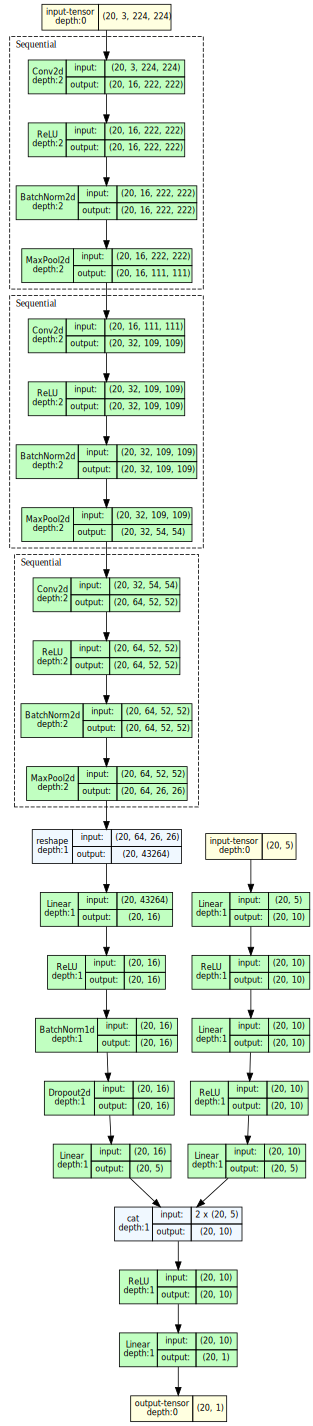

In [142]:

def conv_block(input_size, output_size):
    block = nn.Sequential(
        nn.Conv2d(input_size, output_size, (3, 3)), nn.ReLU(), nn.BatchNorm2d(output_size), nn.MaxPool2d((2, 2)),
    )

    return block

class LitClassifier(nn.Module):
    def __init__(
        self, lr: float = 1e-3, num_workers: int = 4, batch_size: int = 32,
    ):
        super().__init__()
        self.lr = lr
        self.num_workers = num_workers
        self.batch_size = batch_size

        self.conv1 = conv_block(3, 16)
        self.conv2 = conv_block(16, 32)
        self.conv3 = conv_block(32, 64)

        self.ln1 = nn.Linear(64 * 26 * 26, 16)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(16)
        self.dropout = nn.Dropout2d(0.5)
        self.ln2 = nn.Linear(16, 5)

        self.ln4 = nn.Linear(5, 10)
        self.ln5 = nn.Linear(10, 10)
        self.ln6 = nn.Linear(10, 5)
        self.ln7 = nn.Linear(10, 1)

    def forward(self, img, tab):
        img = self.conv1(img)
        img = self.conv2(img)
        img = self.conv3(img)
        img = img.reshape(img.shape[0], -1)
        img = self.ln1(img)
        img = self.relu(img)
        img = self.batchnorm(img)
        img = self.dropout(img)
        img = self.ln2(img)
        # img = self.relu(img)

        tab = self.ln4(tab)
        tab = self.relu(tab)
        tab = self.ln5(tab)
        tab = self.relu(tab)
        tab = self.ln6(tab)
        # tab = self.relu(tab)

        x = torch.cat((img, tab), dim=1)
        x = self.relu(x)

        print(self.ln6.in_features)
        print(self.ln2.in_features)

        return self.ln7(x)
    
model = LitClassifier()
batch_size = 20
image = torch.rand(batch_size, 3, 224, 224)
state = torch.rand(batch_size, 5)

# out = model(image, state)

model_graph = draw_graph(model, input_size=[(batch_size, 3, 224, 224), (batch_size, 5)], expand_nested=True)
model_graph.visual_graph